## Sunspot task

The Sunspot task consists in a next-step prediction (autoregressive, a particular case of transduction) on a [time-series](https://drive.google.com/file/d/1GK5fqzuAGoo466PIxhnwxtSP0r3uDFWa/view?usp=sharing) consisting in monthly averaged solar sunspots.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
import itertools

from liquid_state_machine import LSM

In [2]:
dset = pd.read_csv('./solar_data.csv', header=None).to_numpy().squeeze()
dset

array([ 58. ,  62.6,  70. , ..., 132. , 105.2, 147. ])

In [3]:
dset.shape

(2899,)

Properly separate input and target data, then split the available data in
- training (first 2398 time steps), and
- test set (the subsequent 500 time steps).

In [4]:
#input_dset, target_dset = dset[:,:-1], dset[:,1:]
x_test = dset[-501:]
train = dset[:2398] 
tsize = int(len(train)*0.75)
x_val = train[tsize:]
x_train = train[:tsize]
y_train, y_val, y_test=x_train[1:], x_val[1:], x_test[1:]
x_train, x_val, x_test = x_train[:-1], x_val[:-1], x_test[:-1]

In [5]:
x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape, y_test.shape

((1797,), (599,), (500,), (1797,), (599,), (500,))

Plot the time series of the sunspots

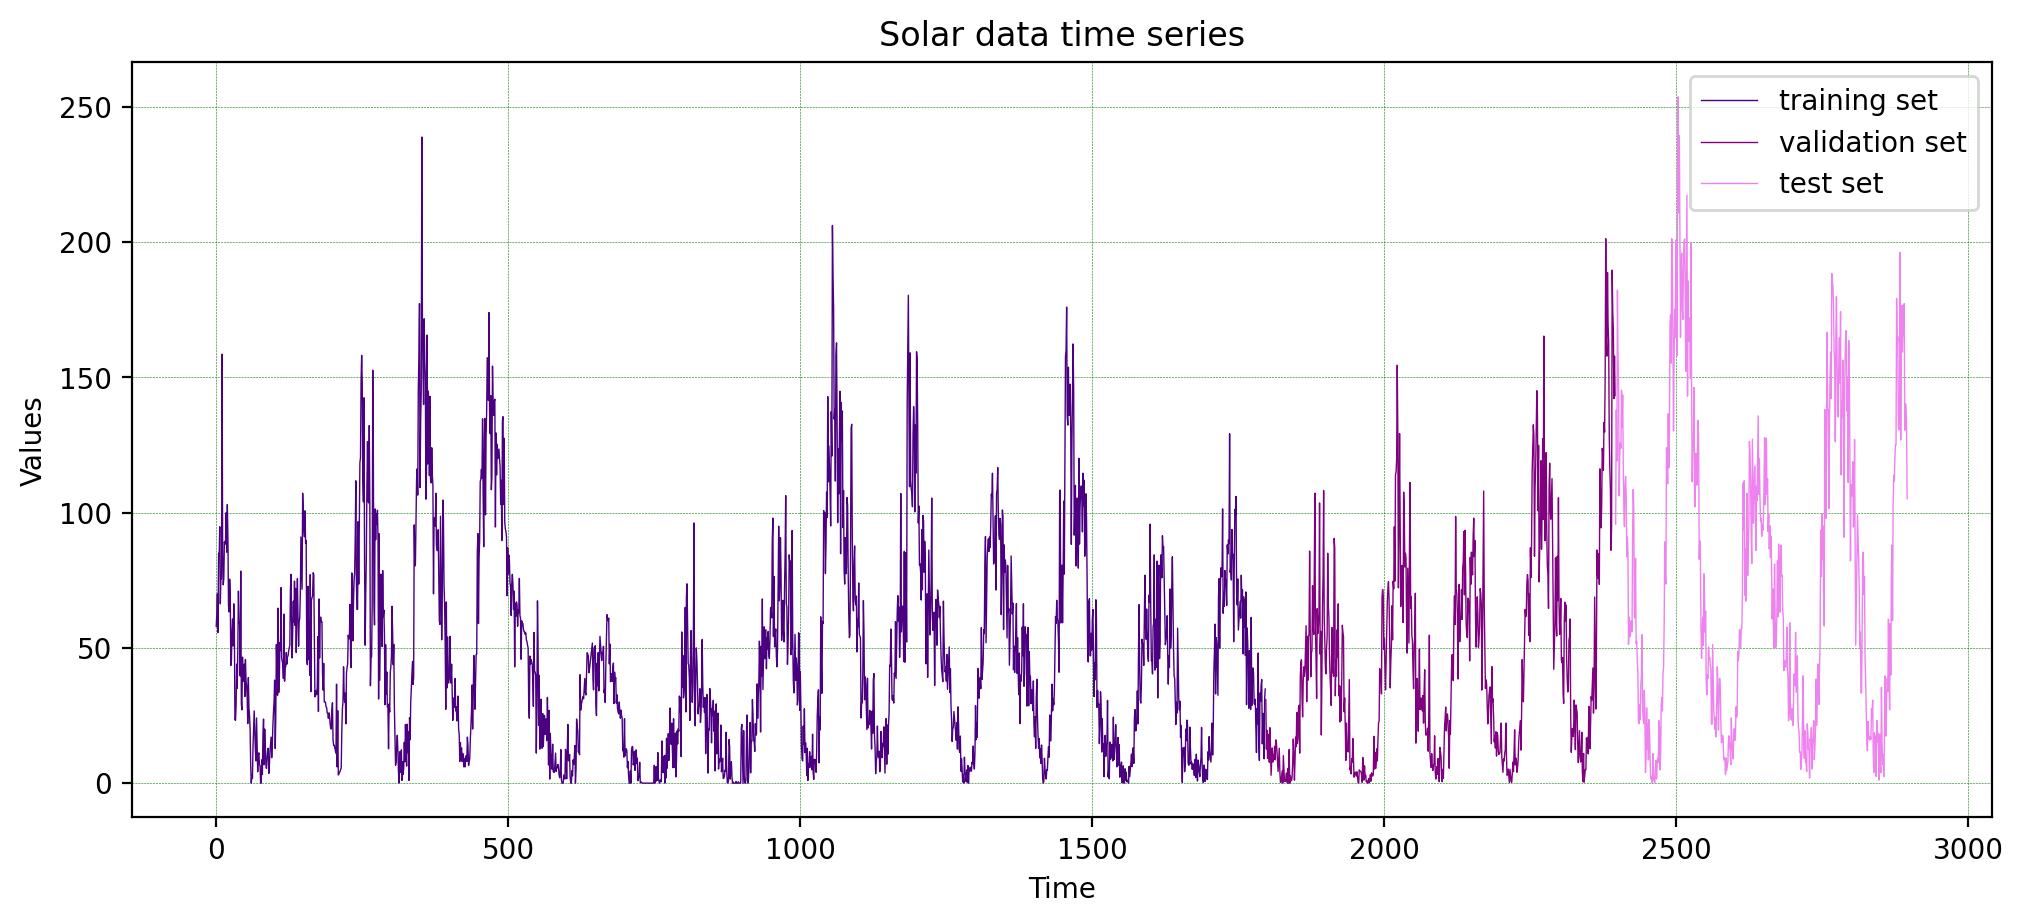

In [6]:
limit1=int(x_train.shape[0])
limit2=int(x_train.shape[0]+x_val.shape[0])
limit3=int(limit2+x_test.shape[0])

plt.figure(figsize=(12,5), dpi=200)
plt.plot(range(0,limit1), x_train, color="indigo", linewidth=0.5, label="training set") 
plt.plot(range(limit1,limit2), x_val, color="purple", linewidth=0.5, label="validation set") 
plt.plot(range(limit2,limit3), x_test, color="violet", linewidth=0.5, label="test set") 

plt.title("Solar data time series")
plt.xlabel("Time")
plt.ylabel("Values")
plt.legend()
plt.grid(color = 'green', linestyle = '--', linewidth = 0.2)
plt.show()

#### Grid search

In [7]:

class GS:
    
    def __init__(self, parameters:dict, Xset:tuple, Yset:tuple):        
        param_grid = self.grid(parameters)
        min_loss, best_cc = self.search(param_grid, Xset, Yset)
        self.min_loss = min_loss
        self.best_cc = best_cc # the best model discovered
    
    # @staticmethod
    def grid(self, params):
        param_names = list(params.keys())
        param_values = list(params.values())
        param_combinations = list(itertools.product(*param_values))
        
        param_grid = []
        for combination in param_combinations:
            param_grid.append(dict(zip(param_names, combination)))
        return param_grid
        
    
    # @staticmethod
    def search(self, param_grid, Xset, Yset):
        predictions={}  
        for pg in param_grid:
            #predictions['ds']=ds
            model = LSM(
                win_e=pg['win_e'],
                win_i=pg['win_i'],
                w_e=pg['w_e'],
                w_i=pg['w_i']
                # ne=pg['ne'],
                # ni=pg['ni']
            )
            Ypred=model.train(Xset, Yset) 
            mae=mean_absolute_error(Yset, Ypred)
            print(f'Parameters: {pg} \n Loss: {mae}')
            predictions[mae]=pg
        
        min_loss = min(predictions.keys())
        best_cc = predictions[min_loss]

        
        return min_loss, best_cc

In [8]:
params={
    'win_e':[2, 4, 6, 8], 
    'win_i':[1, 2, 4, 5],
    'w_e':[0.2, 0.8, 1.2, 1.5],
    'w_i':[0.5, 1, 1.5, 2]
    # 'ne':[700, 800, 950],
    # 'ni':[150, 200, 250]
}

grid_search = GS(params, x_train, y_train) 
best_loss, best_ds = grid_search.min_loss, grid_search.best_cc
print(f'MAE: {best_loss}, configuration: {best_ds}')

Parameters: {'win_e': 2, 'win_i': 1, 'w_e': 0.2, 'w_i': 0.5} 
 Loss: 13.36754668591461
Parameters: {'win_e': 2, 'win_i': 1, 'w_e': 0.2, 'w_i': 1} 
 Loss: 14.11858938431473
Parameters: {'win_e': 2, 'win_i': 1, 'w_e': 0.2, 'w_i': 1.5} 
 Loss: 14.149657591953614
Parameters: {'win_e': 2, 'win_i': 1, 'w_e': 0.2, 'w_i': 2} 
 Loss: 16.111147714580028
Parameters: {'win_e': 2, 'win_i': 1, 'w_e': 0.8, 'w_i': 0.5} 
 Loss: 20.233352859944805
Parameters: {'win_e': 2, 'win_i': 1, 'w_e': 0.8, 'w_i': 1} 
 Loss: 19.72287760975784
Parameters: {'win_e': 2, 'win_i': 1, 'w_e': 0.8, 'w_i': 1.5} 
 Loss: 16.947181550846924
Parameters: {'win_e': 2, 'win_i': 1, 'w_e': 0.8, 'w_i': 2} 
 Loss: 13.785278774681162
Parameters: {'win_e': 2, 'win_i': 1, 'w_e': 1.2, 'w_i': 0.5} 
 Loss: 14.563553734686453
Parameters: {'win_e': 2, 'win_i': 1, 'w_e': 1.2, 'w_i': 1} 
 Loss: 14.797959159530416
Parameters: {'win_e': 2, 'win_i': 1, 'w_e': 1.2, 'w_i': 1.5} 
 Loss: 16.69537029936699
Parameters: {'win_e': 2, 'win_i': 1, 'w_e': 1.

In [9]:
# Validation with best params
model = LSM(win_e=best_ds['win_e'],                
            win_i=best_ds['win_i'],
                w_e=best_ds['w_e'],
                w_i=best_ds['w_i'])
                # ne=best_ds['ne'],
                # ni=best_ds['ni'])
y_pred=model.train(x_val, y_val) 
val_mae=mean_absolute_error(y_val, y_pred)
print(f"Validation MAE: {val_mae}")

Validation MAE: 6.694239647500667


In [10]:

# Retrain on the full training set and test
x_trset = np.concatenate([x_train, x_val])
y_trset = np.concatenate([y_train, y_val])

train_pred = model.train(x_trset, y_trset)
train_mae=mean_absolute_error(y_trset, train_pred)
print(f"Training MAE: {train_mae}")

test_pred = model.train(x_test, y_test)
test_mae=mean_absolute_error(y_test, test_pred)
print(f"Test MAE: {test_mae}")

Training MAE: 14.135355721686265
Test MAE: 14.265799522330592


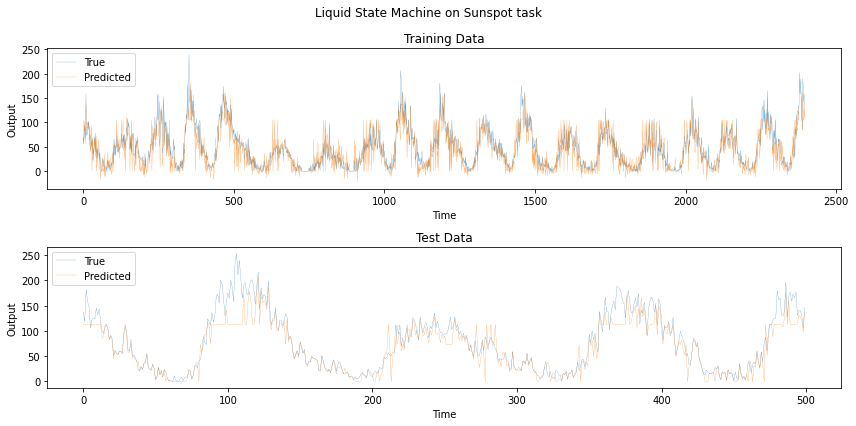

In [12]:
# Plotting the results
plt.figure(figsize=(12, 6))
plt.suptitle('Liquid State Machine on Sunspot task')

plt.subplot(2, 1, 1)
plt.plot(y_trset, label="True",linewidth=0.2)
plt.plot(train_pred, label="Predicted", linewidth=0.2)
plt.title('Training Data')
plt.xlabel('Time')
plt.ylabel('Output')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(y_test, label="True", linewidth=0.2)
plt.plot(test_pred, label="Predicted", linewidth=0.2)
plt.title('Test Data')
plt.xlabel('Time')
plt.ylabel('Output')
plt.legend()

plt.tight_layout()
plt.savefig(str('plots/LSM_results.jpeg'), edgecolor='black', dpi=400, transparent=True)
plt.show()
    